# Turkish Insurance Non-life Market Analysis

![Created with DALL-E 3. Prompt: A professional workspace depicting Turkish Insurance Market data analysis using Python. The scene includes a computer screen with Python code and charts, showcasing insurance market trends and statistics specific to Turkey. The desk is neat, with a Turkish flag, a cup of coffee, and some notes related to the data analysis. The background is an office setting with a view of a cityscape, subtly hinting at the dynamic business environment of Turkey.](https://i.ibb.co/GkLCq4b/Turkish-Insurance-Market-Project-Cover.png)

## Project Outline

1. Objectives
2. Data Collection
3. Data Cleaning and Preparation
4. Exploratory Data Analysis
5. Interpreting Results
6. Review and Next Steps


### 1. Objectives

This project aims to conduct a brief analysis of the Turkish non-life insurance market using Python.


### 2. Data Collection

The data used in this project is collected from the publicly available statistics page of the Insurance Association of Turkey (TSB). <br> To access this data: https://tsb.org.tr/tr/istatistikler
- Genel Sigorta Verileri
- Prim Adet
- 2023
- 1 Direkt Endirekt Primler <br>


#### Description of Data

- **CompanyID:** A unique identifier assigned to each insurance company.
- **CompanyName:** The name of the insurance company.
- **CompanyType:** The type of the insurance company (e.g., pension, life, non-life).
- **BranchID:** A unique identifier for each branch of the insurance product.
- **BranchName:** The branch name of the insurance product (e.g., casco, health).
- **Month:** The month during which the data was recorded.
- **Year:** The year in which the data was collected.
- **MonthlyPremium:** The total premium amount generated by the company in the specific month.
- **TotalPremium:** The cumulative premium amount generated by the company until the specific month.


### 3. Data Cleaning and Preprocessing
In this step, the Excel data downloaded from the TSB is transformed into Pandas dataframe format. <br> 
I added detailed comments on all processes. <br>
This step may seem complicated at first. This is because the Excel files published by the TSB are very poorly designed. <br>
I strongly recommend to download and review the Excel file from the TSB's website for easy understanding.


#### Raw data
![Excel data published by TSB.](https://i.ibb.co/VVg90L2/TSB-Data-Excel.png)
<br>

#### Transformed data
![Transformed data in the Pandas dataframe.](https://i.ibb.co/R4JpLyv/Transformed-Data-Pandas.png)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
# List all Excel files in a specific folder using os library
excel_files = []
folder_path = 'tsb_premium_data'

# Loop through all files in a folder
for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        excel_files.append(file)

In [3]:
# Creating a master dataframe to store dataframes extracted from Excel
master_df = pd.DataFrame()

for file in excel_files:
    # Extracting year and month from file name (sample file name: '1_Direct_Indirect_Premiums_2023-01_NXA1miJ.xlsx'))
    year = int(file[26:30])
    month = int(file[31:33])
    
    # Reading the 'Hayatdışı' sheet in Excel as a dataframe
    file_path = os.path.join(folder_path, file)
    excel_sheet_df = pd.read_excel(file_path, sheet_name='Hayatdışı')
    
    # Swapping BranchID and BranchName rows as BranchName is not unique
    swap_rows = {3: 4, 4: 3}
    excel_sheet_df = excel_sheet_df.rename(swap_rows).sort_index()
    
    # Adding headers manually to the BranchIDs row
    excel_sheet_df.iat[4,0] = 'CompanyName'
    excel_sheet_df.iat[4,1] = 'CompanyID'
    excel_sheet_df.iat[4,2] = 'CompanyType'
    
    # Reading the table with data as dataframe starting from row 5
    new_header = excel_sheet_df.iloc[4]
    excel_table_df = excel_sheet_df[5:]
    excel_table_df.columns = new_header
    excel_table_df.reset_index(drop=True, inplace=True)
    
    # Dropping unnecessary columns from the data
    drop_columns = [701, 785, 906, 907, np.nan] # These columns contain the sum of certain branches. Ex: 701 = 900 + 901 + 902
    excel_table_df.drop(columns=drop_columns, inplace=True)

    # Dropping unnecessary rows from the data
    excel_table_df = excel_table_df[~excel_table_df['CompanyName'].str.contains("TOPLAM")]
    
    # Melting BranchIDs in columns into rows
    melted_df = pd.melt(excel_table_df, id_vars=['CompanyID', 'CompanyName', 'CompanyType'],
                  var_name='BranchID', value_name='TotalPremium')
    
    # Adding Month and Year values to dataframe
    melted_df['Month'] = month
    melted_df['Year'] = year
    
    # Correcting the order of columns
    melted_df = melted_df[['CompanyID', 'CompanyName', 'CompanyType', 'BranchID', 'Month', 'Year', 'TotalPremium']]
    
    # Adding each dataframe to master_df
    master_df = pd.concat([master_df, melted_df], ignore_index=True)

In [4]:
# The data shared by TSB shows the cumulative premium amount up to that month
# In this step, the cumulative premium data was transformed into monthly premium

# Sorting the DataFrame by CompanyID, BranchID, Year, and then by Month to ensure order
master_df.sort_values(by=['CompanyID', 'BranchID', 'Year', 'Month'], inplace=True)

# Grouping the data by CompanyID, BranchID, and Year, and then calculate the monthly premium within each group
master_df['MonthlyPremium'] = master_df.groupby(['CompanyID', 'BranchID', 'Year']
                                               )['TotalPremium'].diff().fillna(master_df['TotalPremium'])

In [5]:
# Creating a new dataframe to store BranchID and BranchNames
# This data can also be retrieved from the same Excel sheet, I inserted it as hard coded for convenience here

branch_ids = [
    701, 900, 901, 902, 702, 703, 704, 705, 706, 707, 708, 710, 711, 712, 713, 714, 715,
    903, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731,
    732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748,
    749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 765, 766, 767, 768,
    769, 770, 771, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 904,
    905, 906, 90601, 90602, 907, 90701, 90702, 786, 789, 798
]

# I deliberately did not translate this data into English to make the analysis easier to understand
branch_names = [
    "Yangın", "Sivil", "Ticari", "Sınai", "Kar Kaybı", "Zorunlu Deprem",
    "Maden Çalışanları Zorunlu Ferdi Kaza", "Doğrudan Kefalet", "Dolaylı Kefalet",
    "Devlet Destekli Alacak Sigortaları", "Bina Tamamlama", "Emtea", "Kıymet",
    "Tekne", "Raylı Araçlar Genel", "Zorunlu Karayolu Tasımacılık Mali Sorumluluk",
    "Zorunlu Trafik (Yeşil Kart Hariç)", "Yeşil Kart",
    "Motorlu Kara Taşıtları İhtiyari Mali Sorumluluk", "Motorlu Kara Taşıtları - Kasko",
    "Karayolu Yolcu Taşımacılığı Zor.Koltuk F.K.", "İşveren Mali Sorumluluk",
    "Üçüncü Şahıslara Karşı Mali Sorumluluk",
    "Asansör Kaza Üçüncü Şahıslara Karşı Mali Sorumluluk",
    "Çevre Kirliliği Mali Sorumluluk", "Cam Kırılması", "Hırsızlık",
    "Tüpgaz Zorunlu Sorumluluk", "Tehlikeli Maddeler Zorunlu Sorumluluk", "Uçak Tekne",
    "Uçak Mali Mesuliyet", "Uçak Yolcu Kaza", "Tıbbı Kötü Uygulamaya İlişkin ZMSS",
    "Özel Güvenlik Mali Sorumluluk", "Zorunlu Sertifika Mali Sorumluluk",
    "Mesleki Sorumluluk", "Kıyı Tesisleri Deniz Kirliliği Zorunlu Mali Sorumluluk",
    "Tekne Sorumluluk", "Emniyeti Suistimal",
    "Motorlu Kara Taşıtları Dışındaki Kara Taşıtları", "Nehir Araçları", "Göl Araçları",
    "İhtiyari Deprem", "Sel", "Deprem ve Sel Dışındaki Doğal Afetler", "Nükleer Enerji",
    "Toprak Kayması", "Taksitli Kredi", "Uzun Vadeli Konut Kredisi", "Tarım Kredisi",
    "İstihdam", "Gelir Yetersizliği", "Ferdi Kaza", "Uzun Süreli Ferdi Kaza",
    "Hava Şartları", "Genel Giderler", "Beklenmeyen Ticari Giderler", "Kredi",
    "İhracat Kredi", "Piyasa Değerindeki Kayıp", "Kira Ve Gelir Kaybı",
    "Diğer Finansal Kayıplar", "Hukuksal Koruma", "Patlama", "Makine Kırılması",
    "Montaj", "İnşaat", "Elektronik Cihaz", "Yapı Denetimi Zorunlu Mali Sorumluluk",
    "Deniz Yolu Yolcu Taşımacılığı ZMS", "Ürün Sorumluluk", "Devlet Destekli Arıcılık",
    "Su Ürünleri", "Dolu Sera", "Devlet Destekli Sera", "Devlet Destekli Bitkisel Ürün",
    "Devlet Destekli Su Ürünleri", "Devlet Destekli Hayvan Hayat", "Hayvan Hayat",
    "Kümes Hayvan Hayat", "Devlet Destekli Kümes Hayvan Hayat",
    "Devlet Destekli Küçükbaş Hayvan Hayat", "Hastalık", "Sağlık Toplam", "Acil Sağlık",
    "Yabancılar için Sağlık", "Tamamlayıcı Sağlık", "Yatarak Tedavi",
    "Yatarak ve Ayakta Tedavi", "Sağlık", "Yatarak Tedavi", "Yatarak ve Ayakta Tedavi",
    "Seyahat Sağlık", "Seyahat Araç Destek", "Destek Genel"
]

# Storing BranchID and BranchName data in a dataframe
df_branches = pd.DataFrame({
    'BranchID': branch_ids,
    'BranchName': branch_names
})

# Adding BranchName values to the master dataframe
master_df = master_df.merge(df_branches, on='BranchID', how='left')

# Correcting the order of columns
column_order = ['CompanyID', 'CompanyName', 'CompanyType', 'BranchID', 'BranchName', 'Month',
                'Year', 'MonthlyPremium', 'TotalPremium']
master_df = master_df.reindex(columns=column_order)


In [6]:
# Exporting the created dataframe in Excel format
# master_df.to_excel('turkish-insurance-non-life-market-analysis.xlsx', encoding='utf-8-sig')

### 4. Exploratory Data Analysis
In this step, I will explore the main characteristics of this dataset using visual methods. <br>

1. Number of insurance branches

2. Ranking of branches by premium production with market share

3. Total premium production by month

4. Premium production of top 5 branches by month

5. Number of insurance companies

6. Number of insurance companies by company type

7. Ranking of companies by premium production

8. Premium production of top 5 companies by month

9. Percentage change in total premium production compared to the previous month


#### 4.1. Number of insurance branches

In [7]:
# 1. Number of insurance branches
num_insurance_branches = master_df['BranchID'].nunique()

print('Number of non-life insurance branches in the Turkish market:', num_insurance_branches)

Number of non-life insurance branches in the Turkish market: 91


#### 4.2. Ranking of branches by premium production with market share

In [8]:
# 2. Ranking of branches by premium production with market share

branch_ranking = master_df.groupby(['BranchID', 'BranchName']
                                  )['MonthlyPremium'].sum().sort_values(ascending=False).reset_index()

total_premiums = branch_ranking['MonthlyPremium'].sum()

branch_ranking['MarketShare'] = (branch_ranking['MonthlyPremium'] / total_premiums) * 100

branch_ranking.head(20)

,BranchID,BranchName,MonthlyPremium,MarketShare
0,715,Zorunlu Trafik (Yeşil Kart Hariç),"74,530,561,042",26
1,717,Motorlu Kara Taşıtları - Kasko,"57,118,436,187",20
2,90702,Yatarak ve Ayakta Tedavi,"24,106,455,938",8
3,902,Sınai,"12,195,348,107",4
4,901,Ticari,"11,570,338,189",4
5,90602,Yatarak ve Ayakta Tedavi,"11,428,310,016",4
6,777,Devlet Destekli Bitkisel Ürün,"8,014,563,293",3
7,740,İhtiyari Deprem,"7,544,188,537",3
8,750,Ferdi Kaza,"7,166,250,849",2
9,90701,Yatarak Tedavi,"6,427,554,101",2


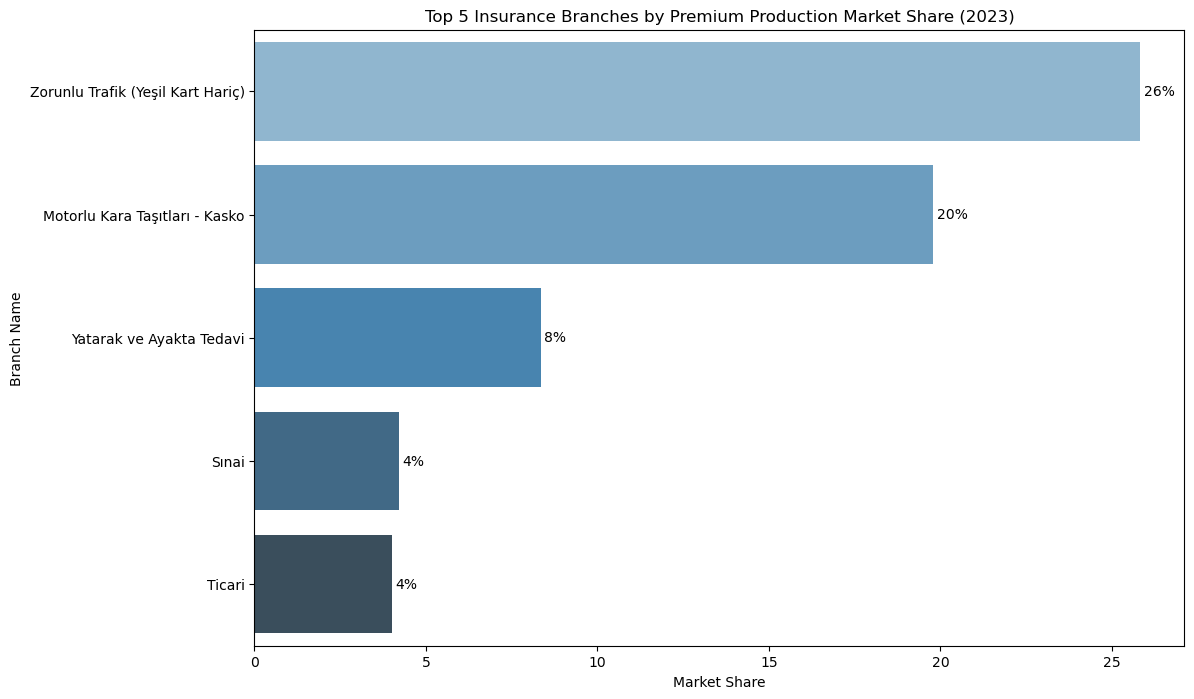

In [9]:
# 2. Ranking of branches by premium production with market share

# Creating a horizontal bar chart for the top 5 insurance branches with labels on the bars
plt.figure(figsize=(12, 8))
plt.tight_layout()

barplot = sns.barplot(x='MarketShare', y='BranchName', data=branch_ranking.head(5), palette="Blues_d")

# Adding labels on the bars
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.1,
             p.get_y() + p.get_height() / 2,
             f'{width:.0f}%',
             va='center')

plt.title('Top 5 Insurance Branches by Premium Production Market Share (2023)')
plt.xlabel('Market Share')
plt.ylabel('Branch Name')
plt.show()

#### 4.3. Total premium production by month

In [10]:
# 3. Total premium production by month

# Calculating total premium production in 2023 by month
monthly_premium_production = master_df[master_df['Year'] == 2023
                                      ].groupby(['Month', 'Year'])['MonthlyPremium'].sum().reset_index()

monthly_premium_production

,Month,Year,MonthlyPremium
0,1,2023,"33,200,261,486"
1,2,2023,"25,729,904,932"
2,3,2023,"33,009,444,665"
3,4,2023,"28,553,795,707"
4,5,2023,"30,772,505,760"
5,6,2023,"34,623,331,645"
6,7,2023,"32,986,054,734"
7,8,2023,"34,941,387,049"
8,9,2023,"34,845,793,269"


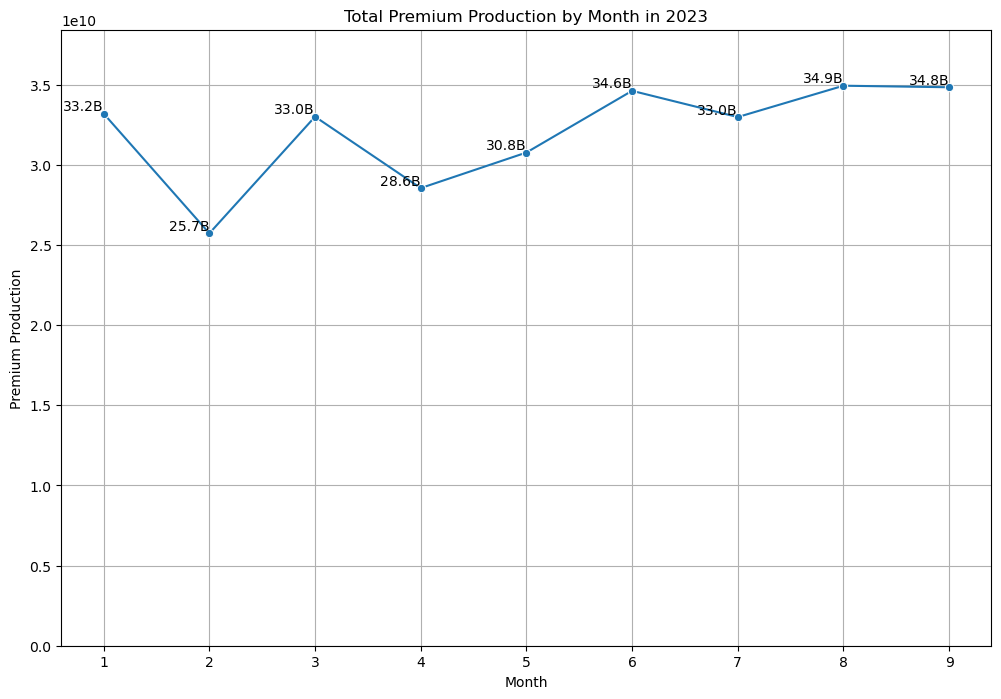

In [11]:
# 3. Total premium production by month

# Formatting the labels to show the values in billions
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x='Month', y='MonthlyPremium', data=monthly_premium_production, marker='o')

# Adjusting the y-axis limits to provide more space for labels
max_premium = monthly_premium_production['MonthlyPremium'].max()
plt.ylim(0, max_premium * 1.1)  # Setting the upper limit to 110% of the maximum value


# Adding labels on the data points with values in billions
for x, y in zip(monthly_premium_production['Month'], monthly_premium_production['MonthlyPremium']):
    plt.text(x, y, f'{y / 1e9:.1f}B', color='black', ha='right', va='bottom')

plt.title('Total Premium Production by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Premium Production')
plt.xticks(range(1, 10))  # Set x-axis ticks for months
plt.grid(True)
plt.show()

#### 4.4. Premium production of top 5 branches by month

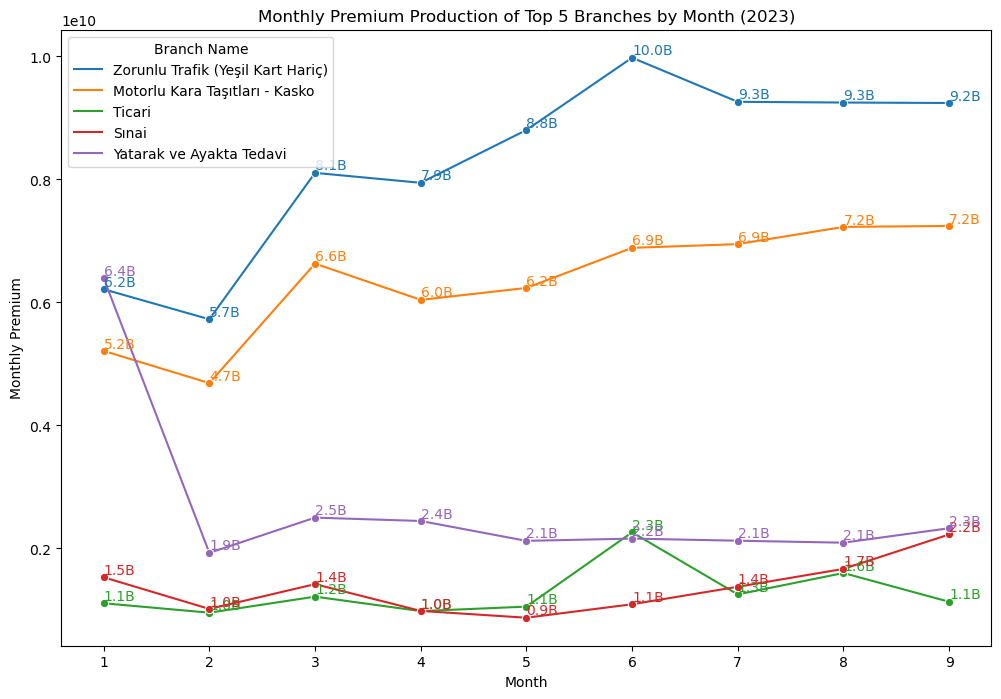

In [12]:
# 4. Premium production of top 5 branches by month

# Identifying the top 5 branches by premium production using CompanyID
# Summing the MonthlyPremium for each branch and then sort them to find the top 5

top_branch_ids = master_df.groupby('BranchID')['MonthlyPremium'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filtering the dataframe to include only the top 5 branches by their IDs
top_branches_df_by_id = master_df[master_df['BranchID'].isin(top_branch_ids)]

# Grouping by both BranchID, BranchName, and Month, then summing the MonthlyPremium
monthly_premium_top_branches_by_id = top_branches_df_by_id.groupby(['BranchID', 'BranchName', 'Month']
                                                                    )['MonthlyPremium'].sum().reset_index()

# Plotting the premium production of top 5 branches by month using MonthlyPremium
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x='Month', y='MonthlyPremium', hue='BranchName', data=monthly_premium_top_branches_by_id,  marker='o')
plt.title('Monthly Premium Production of Top 5 Branches by Month (2023)')
plt.xlabel('Month')
plt.ylabel('Monthly Premium')
plt.legend(title='Branch Name')

# Adding labels on the markers
for line in lineplot.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        plt.text(x, y, f'{y / 1e9:.1f}B', color=line.get_color(), verticalalignment='bottom', horizontalalignment='left')


plt.show()

#### 4.5. Number of insurance companies

In [13]:
# 5. Number of insurance companies
num_insurance_companies = master_df['CompanyID'].nunique()

print('Number of companies in the Turkish insurance market:', num_insurance_companies)

Number of companies in the Turkish insurance market: 69


#### 4.6. Number of insurance companies by company type

In [14]:
# 6. Number of insurance companies by company type
# (E = 'Emeklilik', H = 'Hayat', HD = 'Hayatdışı')

master_df.groupby('CompanyType')['CompanyID'].nunique().reset_index()

,CompanyType,CompanyID
0,E,15
1,H,5
2,HD,49


#### 4.7. Ranking of companies by premium production

In [15]:
# 7. Ranking of companies by premium production
company_ranking = master_df.groupby(['CompanyID', 'CompanyName']
                                   )['MonthlyPremium'].sum().sort_values(ascending=False).reset_index()

# Calculating market share for each company
total_market_premium = company_ranking['MonthlyPremium'].sum()
company_ranking['MarketShare'] = (company_ranking['MonthlyPremium'] / total_market_premium) * 100

company_ranking.head(20) # Displaying the top entries for review

,CompanyID,CompanyName,MonthlyPremium,MarketShare
0,1020,Türkiye Sigorta AŞ,"38,697,247,528",13
1,1004,Allianz Sigorta AŞ,"31,101,278,186",11
2,1005,Anadolu Anonim Türk Sigorta Şirketi,"28,491,876,183",10
3,1009,Axa Sigorta AŞ,"19,767,774,721",7
4,1022,HDI Sigorta AŞ,"17,981,407,340",6
5,1003,Aksigorta AŞ,"17,843,118,565",6
6,1045,Quick Sigorta AŞ,"13,813,584,102",5
7,1035,Sompo Sigorta AŞ,"12,109,039,879",4
8,2001,Bupa Acıbadem Sigorta AŞ,"9,445,730,638",3
9,1032,Ray Sigorta AŞ,"8,098,853,727",3


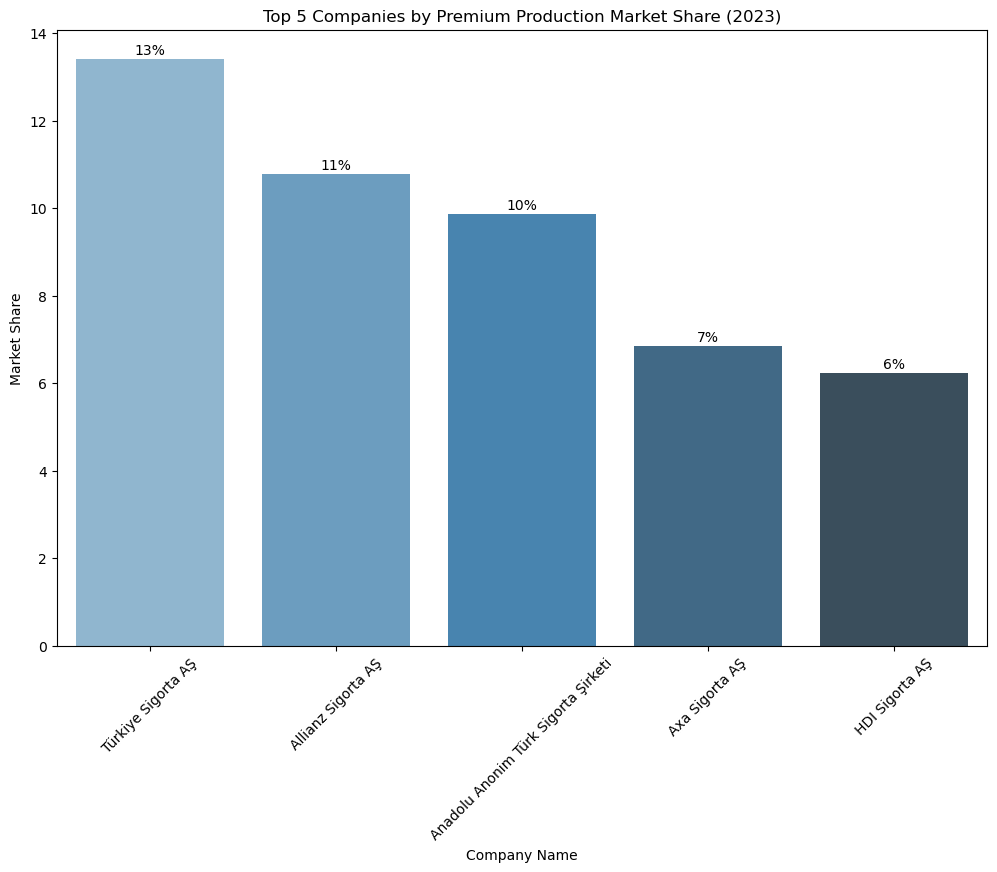

In [16]:
# 7. Ranking of companies by premium production

# Creating a vertical bar chart
plt.figure(figsize=(12, 8))
plt.tight_layout()

barplot = sns.barplot(x='CompanyName', y='MarketShare', data=company_ranking.head(5), palette="Blues_d")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding labels on the bars
for p in barplot.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, 
             height + 0.1,                  
             f'{height:.0f}%',              
             ha='center')                   

plt.title('Top 5 Companies by Premium Production Market Share (2023)')
plt.xlabel('Company Name')
plt.ylabel('Market Share')
plt.show()

#### 4.8. Premium production of top 5 companies by month

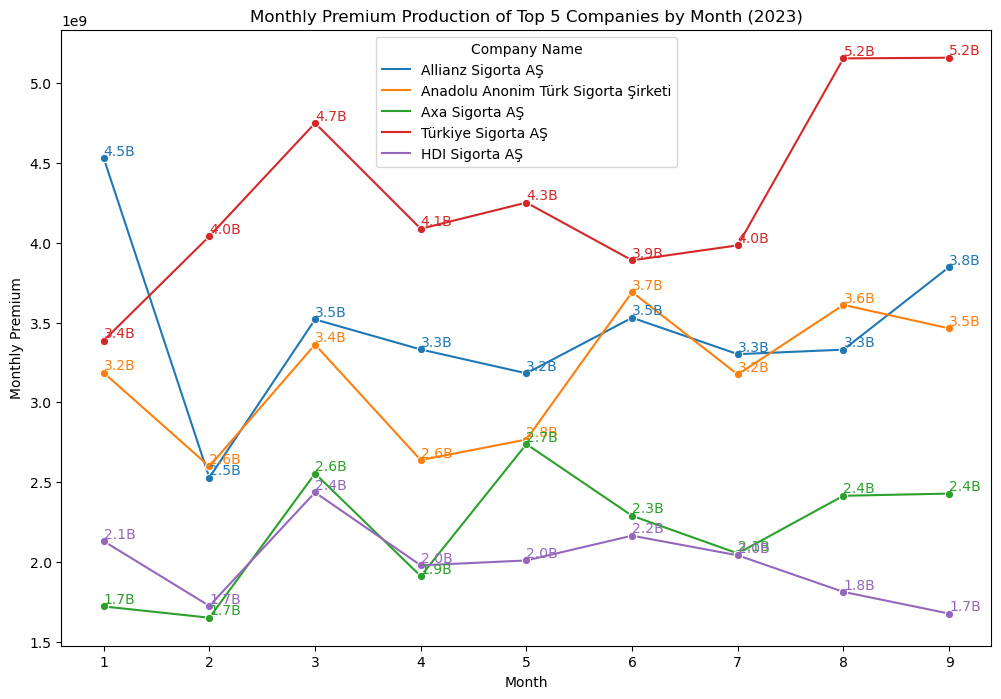

In [17]:
# 8. Premium production of top 5 companies by month

top_company_ids = master_df.groupby('CompanyID')['MonthlyPremium'].sum().sort_values(ascending=False).head(5).index.tolist()

top_companies_df_by_id = master_df[master_df['CompanyID'].isin(top_company_ids)]

monthly_premium_top_companies_by_id = top_companies_df_by_id.groupby(['CompanyID', 'CompanyName', 'Month']
                                                                    )['MonthlyPremium'].sum().reset_index()

# Plotting the premium production of top 5 companies by month using MonthlyPremium
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x='Month', y='MonthlyPremium', hue='CompanyName', data=monthly_premium_top_companies_by_id,  marker='o')
plt.title('Monthly Premium Production of Top 5 Companies by Month (2023)')
plt.xlabel('Month')
plt.ylabel('Monthly Premium')
plt.legend(title='Company Name')

# Adding labels on the markers
for line in lineplot.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        plt.text(x, y, f'{y / 1e9:.1f}B', color=line.get_color(), verticalalignment='bottom', horizontalalignment='left')


plt.show()

#### 4.9. Percentage change in total premium production compared to the previous month

posx and posy should be finite values
posx and posy should be finite values


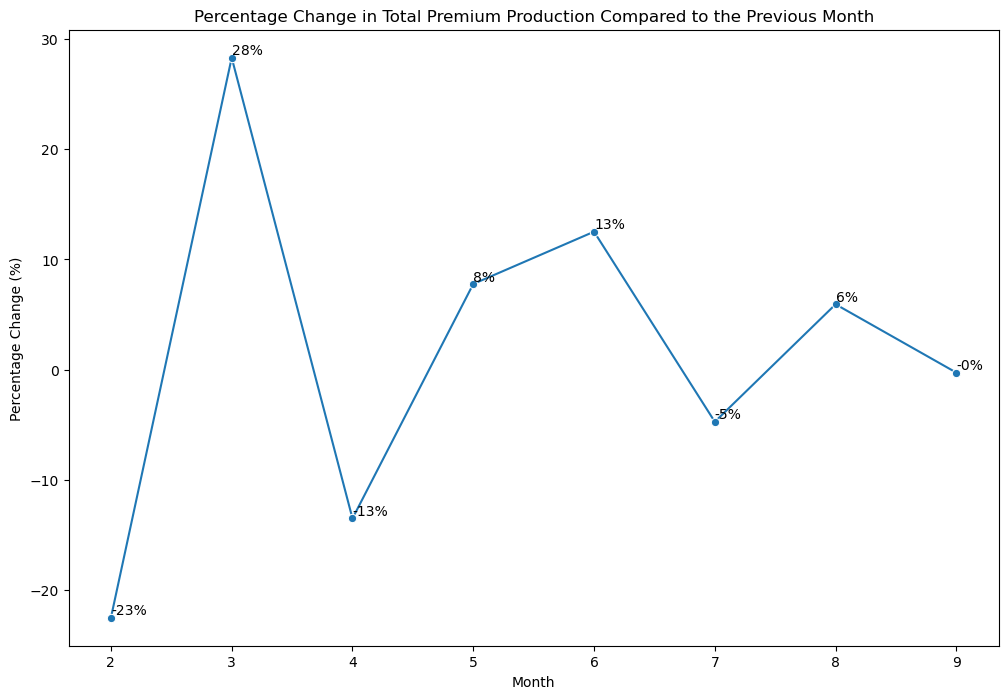

In [18]:
# Summing the MonthlyPremium for each month
total_monthly_premium = master_df.groupby('Month')['MonthlyPremium'].sum()

# Calculating the percentage change
monthly_premium_percentage_change = total_monthly_premium.pct_change() * 100

# Resetting index to convert the series to a dataframe
monthly_premium_percentage_change = monthly_premium_percentage_change.reset_index()

# Plotting the premium production percentage by month
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x='Month', y='MonthlyPremium', data=monthly_premium_percentage_change, marker='o')
plt.title('Percentage Change in Total Premium Production Compared to the Previous Month')
plt.xlabel('Month')
plt.ylabel('Percentage Change (%)')

# Adding y labels to each marker
for x, y in zip(monthly_premium_percentage_change['Month'], monthly_premium_percentage_change['MonthlyPremium']):
    plt.text(x, y, f'{y:.0f}%', color='black', verticalalignment='bottom', horizontalalignment='left')

plt.show()

### 5. Interpreting Results

**Number of insurance branches**

There are 91 branches in the non-life insurance sector. <br> <br>

**Ranking of branches by premium production with market share**

The largest insurance branches in the sector are Zorunlu Trafik (MTPL) and Kasko (Casco). According to their premium production, they have 26% and 20% market share. <br> <br>

**Total premium production by month**

Monthly premium production is between 25-35 billion TL. The lowest month is February as the earthquake on February 6 significantly impacted a vast area and millions of people. Premium production seems stable from June to September. Please note that these figures are not adjusted for inflation. (There is no institution that measures the real inflation anyway.) <br> <br>

**Premium production of top 5 branches by month**

In the 5 largest branches, MTPL and Casco are in line with each other. Premiums remained the same in July-August-September. Considering the inflation, there may be a contraction in the car market.

Yatarak ve Ayakta Tedavi (Inpatient and Outpatient Health) branch produced 6.5 billion TL premiums in January, but it produced around 2 billion TL in February and onwards. This may be due to the fact that companies renew their employee insurances at the beginning of the year. 

Ticari ve Sınai (Commercial and Industrial) insurance branches progressed in parallel with each other every month. <br> <br>

**Number of insurance companies**

There are 69 companies in the Turkish insurance market. <br> <br>

**Number of insurance companies by company type**

49 of these companies operate in the field of non-life insurance. 15 of them are in pension and 5 in life insurance. <br> <br>

**Ranking of companies by premium production**

The largest company with a 13% market share is Türkiye Sigorta, managed by the Türkiye Wealth Fund under the Presidency of the Republic of Turkey.

It is followed by Allianz with 11% market share and Anadolu Sigorta with 10%.

Axa Sigorta and HDI Sigorta have 7% and 6% market shares, respectively.

The top 5 companies produce roughly 50% of total non-life insurance premium. <br> <br>

**Premium production of top 5 companies by month**

Four of the five largest companies follow similar trends. Türkiye Sigorta, on the other hand, differs from the other companies. <br> <br>

**Percentage change in total premium production compared to the previous month**

Although there was a decline in the first months of the year, there is an increase after May. One reason for this may be the presidential elections that took place in May. <br>


### 6. Review and Next Steps
In this project, I used pandas, numpy, seaborn, matplotlib libraries. A similar work can be done with different tools, the main reason I chose Python and its libraries is that these tools have large developer communities.

As it is usually the case in data analysis projects, the most challenging part was getting the data into the right format. It was important that the preprocessing was accurate.

**Next steps**

- The preprocessing performed here can be generalized to work on other Excel files/sheets that the TSB shares.
- In order to use the preprocessing script, it is necessary to manually download the relevant Excel files from the TSB site and put them in folders. This process can be automated.
- An interface can be designed to make this analysis easier for non-technical users to use.
- I deliberately chose the non-life market as it is the largest market in the Turkish insurance sector. A similar study can be conducted for the life insurance market.
- The analysis is based on 2023 data. It can be extended with data from 2022 and earlier.
- This data only includes premium production. The TSB also shares data such as the number of policies and sales channels. All data can be combined together and a more comprehensive analysis can be carried out.
- Using this data, insurance companies can design dashboards with Power BI, Tableau, etc. and track their performance and market position.

If you have any questions or suggestions about this project, you can contact me at my [email address](mailto:talhakose034@hotmail.com).